In [1]:
!pip install lime

import shutil
import random
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import pathlib

import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import seed
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
#from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Set random seed for reproducibility
seed_train_validation = 42
tf.random.set_seed(seed_train_validation)
np.random.seed(seed_train_validation)

2024-02-01 19:13:36.357045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 19:13:36.357173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 19:13:36.523486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/508764030.py:27: DeprecationWarning: Please import `QhullError` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.qhull import QhullError


In [2]:
# Directory paths
train_data_dir = '/kaggle/input/aml-flowers-dataset/train_images_by_class/train_images_by_class'
val_data_dir = '/kaggle/input/aml-flowers-dataset/validation_images_by_class/validation_images_by_class'
test_data_dir = '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class'

# Image size
image_size = (299, 299)

batch_size = 64

In [3]:
# Creazione del generatore di dati
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    brightness_range=[1-0.3, 1+0.3],
    zoom_range=[1-0.2, 1+0.2],
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size, 
    batch_size=batch_size,  
    class_mode="categorical",  
    shuffle=True,
    seed = 42
)

Found 1020 images belonging to 102 classes.


In [4]:
# Validation and test data generators without data augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.


In [5]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/inception-final/inception_final_unfreeze.h5')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


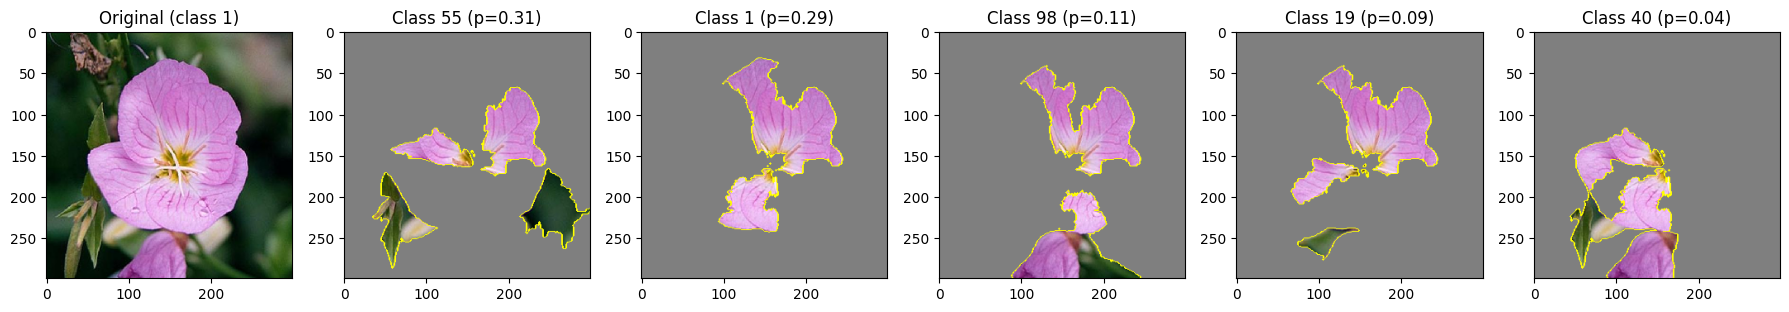

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


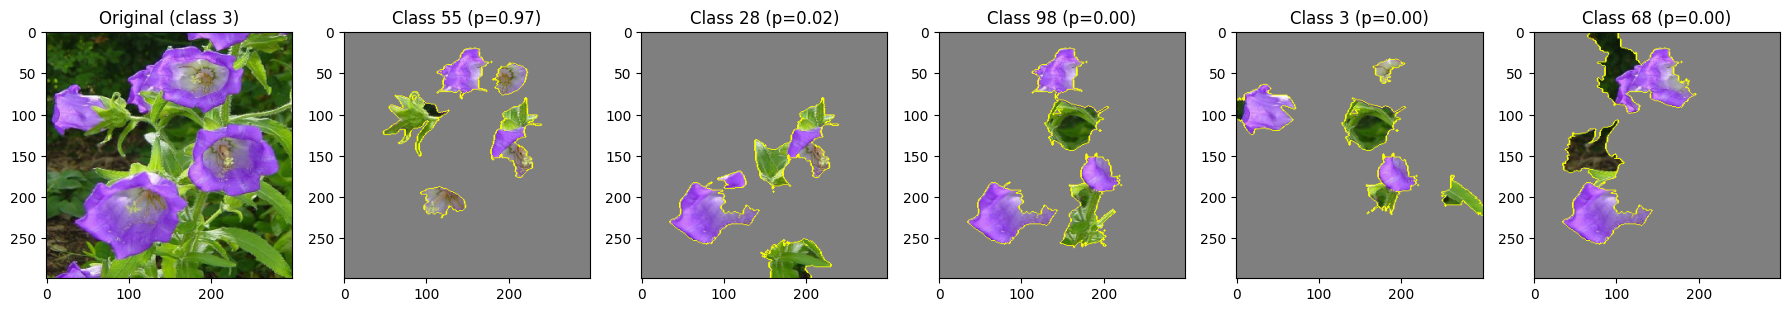

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


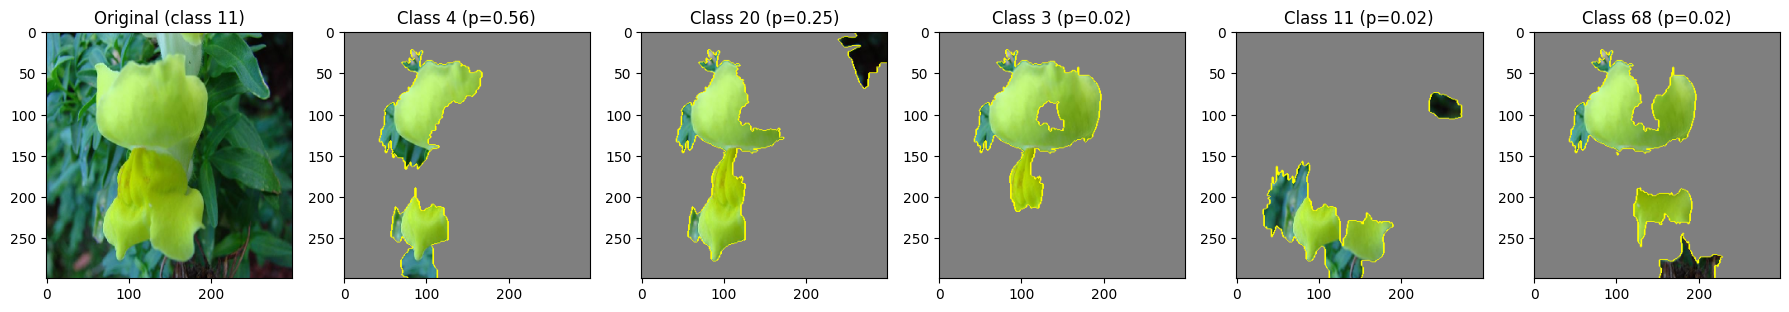

In [8]:
# Percorsi delle immagini da spiegare
image_paths = [
    '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/1/image_06734.jpg',
    '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/3/image_06613.jpg',
    '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/11/image_03095.jpg'
]

true_labels = [1, 3, 11]

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Generate plot for each explanation
for idx, img_path in enumerate(image_paths):
    # Carica l'immagine con la dimensione corretta
    img = image.load_img(img_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img_preprocessed = preprocess_input(img.copy())  # Preprocess the image using InceptionV3's preprocess_input
    
    true_label = true_labels[idx]
    pred = model.predict(img_preprocessed, verbose=0)
    predicted_class = pred.argmax(axis=-1)

    # get the LIME explanation
    explanation = explainer.explain_instance(img_preprocessed[0].astype('double'), 
                                             model.predict,
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)

    # Visualization
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(np.uint8(img[0]))  # Convert the preprocessed image back to uint8 type
    plt.title(f'Original (class {true_label})')

    for i in range(5):
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=True)
        plt.subplot(1, 6, i+2)
        img_boundry = mark_boundaries(temp / 2 + 0.5, mask)
        plt.imshow(img_boundry)
        prob = pred[0][explanation.top_labels[i]]
        class_index = explanation.top_labels[i]
        class_name = class_names[class_index]
        
        plt.title(f'Class {class_name} (p={prob:.2f})') 
    plt.tight_layout()
    plt.show()
